In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from config import get_from_config
import fur.path_assistant as path_assistant
from touschek.touschek import get_LamTska, get_Touschek_Lifetime_Lebedev,\
                                get_Touschek_Lifetime_Valishev
shift = path_assistant.PathAssistant('shift_03_16_2020')
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
cur_to_sum_channel = get_from_config("Beam_current_to_Sum_channel_ampl_V/mA")
sum_channel_to_photoelectrons = get_from_config('sum_channel_to_photoelectrons')
N_to_I = 1/sum_channel_to_photoelectrons/cur_to_sum_channel
i_to_photoel = 1/N_to_I
meas_ROUND = pd.read_csv(shift.get_results_dir().fi('meas_ROUND_03_16_2020.csv'), index_col=0)
meas_ROUND = meas_ROUND.sort_values(by='N',ignore_index=True)

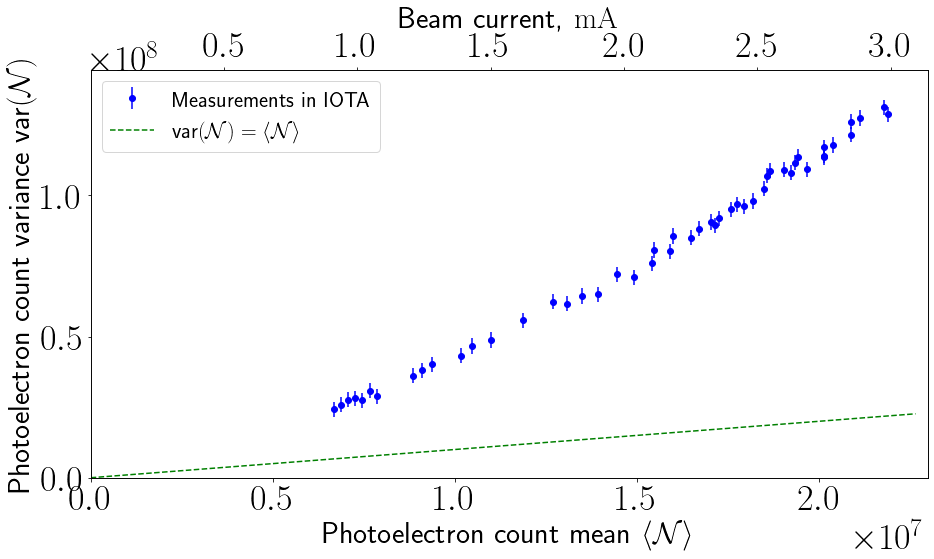

In [2]:
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=r'\usepackage{siunitx}')
plt.rcParams.update({'font.size': 36,'legend.fontsize':22})
colors = {"FLAT": 'blue'}

fig, ax = plt.subplots(figsize=(15, 7.5))
ax.errorbar(meas_ROUND['N'],meas_ROUND['varN'],marker='o',linestyle='None',
            yerr=meas_ROUND['errorbar'],color='b',
            label = r'Measurements in IOTA')
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',
        label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
handles, labels = ax.get_legend_handles_labels()
order = [1,0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax.set_xlim(0, 1.05*meas_ROUND['N'].max())
ax.set_ylim(0, 1.1*meas_ROUND['varN'].max())
ax1 = ax.twiny()
ax1.set_xlabel('Beam current, \SI{}{mA}')
ax1.set_xlim(N_to_I*np.asarray(ax.get_xlim()))
ax1.set_xticks(ticks=ax1.get_xticks()[1:-1])
plt.show()

In [3]:
df = pd.read_csv("M_on_grid_precalc.csv", index_col=0)
df_EB = pd.read_csv("M_on_grid_precalc_EB.csv", index_col=0)
df_ET = pd.read_csv("M_on_grid_precalc_ET.csv", index_col=0)

In [4]:
df.head()

,0.06,0.06857142857142857,0.07714285714285714,0.08571428571428573,0.09428571428571428,0.10285714285714287,0.11142857142857143,0.12
6.693879e+06,2.221984e+06,2.478707e+06,2.738453e+06,3.001321e+06,3.267457e+06,3.536921e+06,3.809616e+06,4.085455e+06
6.868607e+06,2.232259e+06,2.489990e+06,2.750771e+06,3.014674e+06,3.281838e+06,3.552339e+06,3.826136e+06,4.103022e+06
7.057312e+06,2.243369e+06,2.502187e+06,2.764074e+06,3.029091e+06,3.297380e+06,3.569039e+06,3.843973e+06,4.122039e+06
7.249983e+06,2.254729e+06,2.514671e+06,2.777677e+06,3.043832e+06,3.313292e+06,3.586113e+06,3.862211e+06,4.141467e+06
7.445827e+06,2.266292e+06,2.527336e+06,2.791512e+06,3.058828e+06,3.329460e+06,3.603451e+06,3.880718e+06,4.161206e+06


In [5]:
es = df.columns.values.astype(np.float64)

In [6]:
es

array([0.06      , 0.06857143, 0.07714286, 0.08571429, 0.09428571,
       0.10285714, 0.11142857, 0.12      ])

In [7]:
def reconstruct_e(avN, varN, en='0'):
    Mexp = avN**2/(varN-avN)
    df0 = {'0':df, 'B':df_EB, 'T':df_ET}[en]
    return np.interp(Mexp,df0.loc[avN,:],es)

In [8]:
reconstruct_e(meas_ROUND['N'][0], meas_ROUND['varN'][0]+0.01e8)

0.06625254563615697

In [9]:
reconstruct_e(meas_ROUND['N'][0], meas_ROUND['varN'][0])

0.07079722174946498

In [10]:
meas_ROUND['e_rec'] = meas_ROUND.apply(
    lambda row: reconstruct_e(*row[['N', 'varN']]), axis=1)
meas_ROUND['e_rec_EB'] = meas_ROUND.apply(
    lambda row: reconstruct_e(*row[['N', 'varN']], en='B'), axis=1)
meas_ROUND['e_rec_ET'] = meas_ROUND.apply(
    lambda row: reconstruct_e(*row[['N', 'varN']], en='T'), axis=1)
meas_ROUND['varNtop'] = meas_ROUND['varN']+meas_ROUND['errorbar']
meas_ROUND['varNbottom'] = meas_ROUND['varN']-meas_ROUND['errorbar']
meas_ROUND['e_error_top'] = meas_ROUND.apply(
    lambda row: reconstruct_e(
        *row[['N', 'varNbottom']]), axis=1)\
        - meas_ROUND['e_rec']
meas_ROUND['e_error_bottom'] = -meas_ROUND.apply(
    lambda row: reconstruct_e(
        *row[['N', 'varNtop']]), axis=1)\
        + meas_ROUND['e_rec']

# Systematic error of reconstructed e due to beam energy uncertainty

In [11]:
# 1e3*meas_ROUND.loc[:,['e_rec_EB', 'e_rec_ET']].apply(lambda col:col-meas_ROUND.loc[:,'e_rec'],axis=0)

In [12]:
meas_ROUND['I_mA'] = meas_ROUND['N']*N_to_I

In [13]:
# calculation of reconstructed sy
import lattice.lattice as lattice
#from lattice.summary_in_undulator import CalcTransverseBeamParams
lattice_df = \
    lattice.read_lattice_file(shift.get_6dsim_dir()\
    .fi("IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"))
from scipy.interpolate import interp1d
bp_df = pd.read_csv(shift.get_results_dir().fi("beam_params_vs_current_round.csv"))
ex_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
dpp_func = interp1d(bp_df["N"], bp_df['dp/p'],
                    bounds_error=False, fill_value="extrapolate")
# def get_sy(row):
#     Sx, Sy, dx, dy, sxp, syp = CalcTransverseBeamParams(
#         lattice_df, ex_func(row['N']), row['ey_rec'], dpp_func(row['N']))
#     return np.sqrt(Sy**2+syp**2*dy**2)
# meas_FLAT["sy_rec"] = meas_FLAT.apply(get_sy, axis=1)

In [14]:
# # save new meas_FLAT with ey and I_mA
# meas_FLAT.to_csv(shift.get_results_dir().fi('meas_FLAT_03_16_2020.csv'))

In [15]:
round_df = pd.read_csv(shift.get_results_dir().fi("full_beam_params_vs_current_round.csv"))

In [16]:
meas_FLAT = pd.read_csv(shift.get_results_dir().fi('meas_FLAT_03_16_2020.csv'), index_col=0)

In [17]:
flat_df = pd.read_csv(shift.get_results_dir().fi("full_beam_params_vs_current_flat.csv"),
                     index_col=0)

In [18]:
from scipy.interpolate import interp1d
bp_df = pd.read_csv(
    shift.get_results_dir().fi("beam_params_vs_current_round.csv"))
sx_r_func = interp1d(bp_df["N"], bp_df['Sigma_um_X'],
                   bounds_error=False, fill_value="extrapolate")
sy_r_func = interp1d(bp_df["N"], bp_df['Sigma_um_Y'],
                   bounds_error=False, fill_value="extrapolate")
sz_r_func = interp1d(bp_df["N"], bp_df['sz_cm_rms'],
                   bounds_error=False, fill_value="extrapolate")
ex_r_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
ey_r_func = interp1d(bp_df["N"], bp_df['ey_um'],
                   bounds_error=False, fill_value="extrapolate")
dpp_r_func = interp1d(bp_df["N"], bp_df['dp/p'],
                    bounds_error=False, fill_value="extrapolate")
Vrf_r_func = interp1d(bp_df["N"], bp_df['N:IRFEPA'],
                    bounds_error=False, fill_value="extrapolate")


bp_df = pd.read_csv(
    shift.get_results_dir().fi("beam_params_vs_current_flat.csv"))
sx_f_func = interp1d(bp_df["N"], bp_df['Sigma_um_X'],
                   bounds_error=False, fill_value="extrapolate")
sy_f_func = interp1d(bp_df["N"], bp_df['Sigma_um_Y'],
                   bounds_error=False, fill_value="extrapolate")
sz_f_func = interp1d(bp_df["N"], bp_df['sz_cm_rms'],
                   bounds_error=False, fill_value="extrapolate")
ex_f_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
ey_f_func = interp1d(bp_df["N"], bp_df['ey_um'],
                   bounds_error=False, fill_value="extrapolate")
dpp_f_func = interp1d(bp_df["N"], bp_df['dp/p'],
                    bounds_error=False, fill_value="extrapolate")
Vrf_f_func = interp1d(bp_df["N"], bp_df['N:IRFEPA'],
                    bounds_error=False, fill_value="extrapolate")

In [19]:
def remove_outliers_omce(df, c1, l1):
    di = df[c1].diff().abs()
    return df[di < l1]
    
def remove_outliers(df, c1, l1, niter):
    for _ in range(niter):
        df = remove_outliers_omce(df, c1, l1)
    return df
round_df = remove_outliers(round_df,'N:IWCMI_recalibrated_to_IWCMI_absolute', 0.1, 10)
round_df = remove_outliers(round_df,'ex_um', 0.01, 10)
round_df = remove_outliers(round_df,'ey_um', 0.01, 10)

flat_df = remove_outliers(flat_df,'N:IWCMI_recalibrated_to_IWCMI_absolute', 0.1, 10)


# Lifetime calculation from fluctuations-based emittance ey

In [20]:
# aperture_factor = 1.0
# lt_f_df = pd.read_csv(shift.get_results_dir().fi(
#     "life_time_flat_03_16_2020.csv"),
#             index_col=0)
# touschek_times_Lebedev = []
# touschek_times_Valishev = []
# for i in meas_FLAT.index:
#     print(f"Working on {i+1} out of {len(meas_FLAT.index)}")
#     row = meas_FLAT.loc[i,:]
#     Ibeam = row['N']/i_to_photoel
#     avN = row['N']
#     V0 = Vrf_f_func(avN)
#     sp = dpp_f_func(avN)
#     ex = ex_f_func(avN)
#     ey = row['ey_rec']
#     sz = sz_f_func(avN)
#     touschek_times_Lebedev.append(
#         get_Touschek_Lifetime_Lebedev(lattice_df, V0, 1e-10, ex, ey, sz, Ibeam,
#                          aperture_factor=aperture_factor))
#     touschek_times_Valishev.append(
#         get_Touschek_Lifetime_Valishev(lattice_df, V0, 0, ex, ey, sz, Ibeam,
#                          aperture_factor=aperture_factor))

In [21]:
# ibeams = meas_FLAT['N']/i_to_photoel
# plt.rcParams["text.usetex"] =True
# plt.rc('text.latex', preamble=\
#        r'\usepackage{siunitx}'
#       +r'\newcommand{\e}{\epsilon}')
# plt.rcParams.update({'figure.figsize':(15,8),
#                      'font.size': 28,
#                      'legend.fontsize':22,
#                      'errorbar.capsize':3})
# fig, ax = plt.subplots()
# ax.plot(lt_f_df['I (mA)'], lt_f_df['Beam life time (Sec)'], '.-',
#        label='Measured lifetime')
# ax.plot(ibeams, touschek_times_Lebedev, '.--',
#        label='Simulation (Lebedev)')
# ax.plot(ibeams, touschek_times_Valishev, '.--',
#        label='Simulation (Valishev)')
# ax.set_ylim(0, ax.get_ylim()[1])
# ax.legend()
# ax.set_xlabel("Beam current (mA)")
# ax.set_ylabel("Lifetime (sec)")
# plt.title(r"Flat beam. $\e_y$ was measured via fluctuations.")
# plt.show()

# Cross check with Mathcad

In [22]:
ex = 5.82e-5*1e4
ey = 0.0037*ex
sz = 33.8
Ibeam = 3.185
V0 = 354
sp = 2.996e-4
get_Touschek_Lifetime_Lebedev(lattice_df, V0, sp, ex, ey, sz, Ibeam,
                         aperture_factor=1.0, gamma=100/0.511)

454.0330070927013

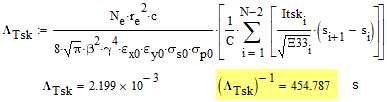

In [23]:
ldf = lattice_df
aperture_factor=1
dict_Leb = {}
leb = get_Touschek_Lifetime_Lebedev(ldf, V0, 1e-10, ex, ey, sz, Ibeam,
                         aperture_factor=aperture_factor, gamma=100/0.511,
                         test_dict=dict_Leb)
dict_Val = {}
val = get_Touschek_Lifetime_Valishev(ldf, V0, 0, ex, ey, sz, Ibeam,
                         aperture_factor=aperture_factor, gamma=100/0.511,
                         test_dict=dict_Val)

# Valeri's equations. Calculation for round beam

In [24]:
aperture_factor = 0.7
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
lt_df = pd.read_csv(shift.get_results_dir().fi(
    "life_time_round_03_16_2020.csv"),
            index_col=0)
lt_df['N'] = i_to_photoel*lt_df['I (mA)']

def get_touschek_times(aperture_factor):
    touschek_times = []
    for i,Ibeam in enumerate(lt_df['I (mA)']):
        print(f"Working on {i+1} out of {len(lt_df.index)}")
        avN = i_to_photoel*Ibeam
        V0 = Vrf_r_func(avN)
        sp = dpp_r_func(avN)
        ex = ex_r_func(avN)
        ey = ey_r_func(avN)
        sz = sz_r_func(avN)
        touschek_times.append(
            get_Touschek_Lifetime_Lebedev(lattice_df, V0, sp, ex, ey, sz, Ibeam,
                             aperture_factor=aperture_factor)
        )
    return touschek_times
ttimes_10 = get_touschek_times(1)
ttimes_07 = get_touschek_times(0.7)

Working on 1 out of 21
Working on 2 out of 21
Working on 3 out of 21
Working on 4 out of 21
Working on 5 out of 21
Working on 6 out of 21
Working on 7 out of 21
Working on 8 out of 21
Working on 9 out of 21
Working on 10 out of 21
Working on 11 out of 21
Working on 12 out of 21
Working on 13 out of 21
Working on 14 out of 21
Working on 15 out of 21
Working on 16 out of 21
Working on 17 out of 21
Working on 18 out of 21
Working on 19 out of 21
Working on 20 out of 21
Working on 21 out of 21
Working on 1 out of 21
Working on 2 out of 21
Working on 3 out of 21
Working on 4 out of 21
Working on 5 out of 21
Working on 6 out of 21
Working on 7 out of 21
Working on 8 out of 21
Working on 9 out of 21
Working on 10 out of 21
Working on 11 out of 21
Working on 12 out of 21
Working on 13 out of 21
Working on 14 out of 21
Working on 15 out of 21
Working on 16 out of 21
Working on 17 out of 21
Working on 18 out of 21
Working on 19 out of 21
Working on 20 out of 21
Working on 21 out of 21


In [25]:
# scipy.optimize.bisect?

In [26]:
# import scipy.optimize
# lt = lt_df.loc[0, 'Beam life time (Sec)']
# Ibeam = lt_df.loc[0, 'I (mA)']
# avN = i_to_photoel*Ibeam
# V0 = Vrf_r_func(avN)
# sp = dpp_r_func(avN)
# sz = sz_r_func(avN)
# def f(e):
#     return lt - get_Touschek_Lifetime_Lebedev(lattice_df, V0, sp, e, e, sz, Ibeam,
#                              aperture_factor=aperture_factor)
# scipy.optimize.bisect(f, 0.05, 0.15, xtol=0.001)

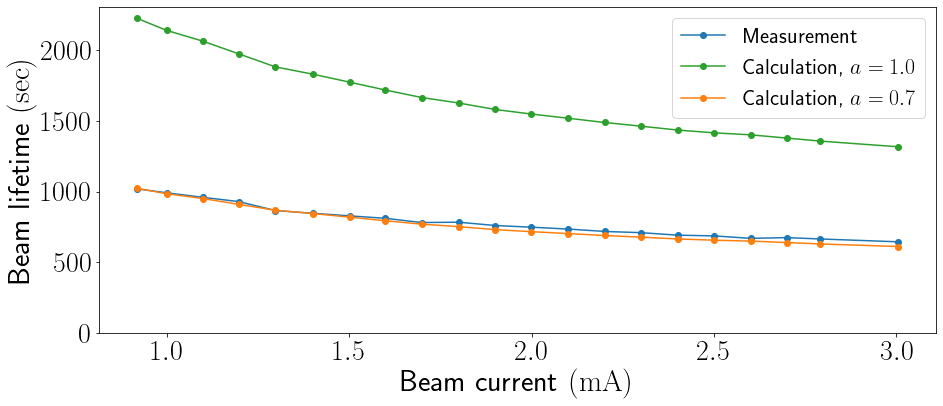

In [32]:
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=\
       r'\usepackage{siunitx}'
      +r'\newcommand{\e}{\epsilon}')
plt.rcParams.update({'figure.figsize':(15,6),
                     'font.size': 28,
                     'legend.fontsize':22,
                     'errorbar.capsize':3})
fig, ax = plt.subplots()
ax.plot(lt_df['I (mA)'], lt_df['Beam life time (Sec)'], '.-', marker='o',
       label='Measurement')
ax.plot(lt_df['I (mA)'], ttimes_10, '.-', marker='o',
       label='Calculation, $a=1.0$', color='tab:green')
ax.plot(lt_df['I (mA)'], ttimes_07, '.-', marker='o',
       label='Calculation, $a=0.7$', color='tab:orange')
ax.set_ylim(0, ax.get_ylim()[1])
ax.legend()
ax.set_xlabel(r"Beam current $(\SI{}{mA})$")
ax.set_ylabel(r"Beam lifetime $(\SI{}{sec})$")
# plt.title(f"Round beam. Momenum aperture factor = {aperture_factor:.2f}")
plt.savefig(path_assistant.get_PRL_images_dir().fi("touschek.png"),
            dpi=300, bbox_inches='tight')
plt.show()

In [28]:
et_df = pd.read_csv("e_from_touschek_round.csv", index_col=0)

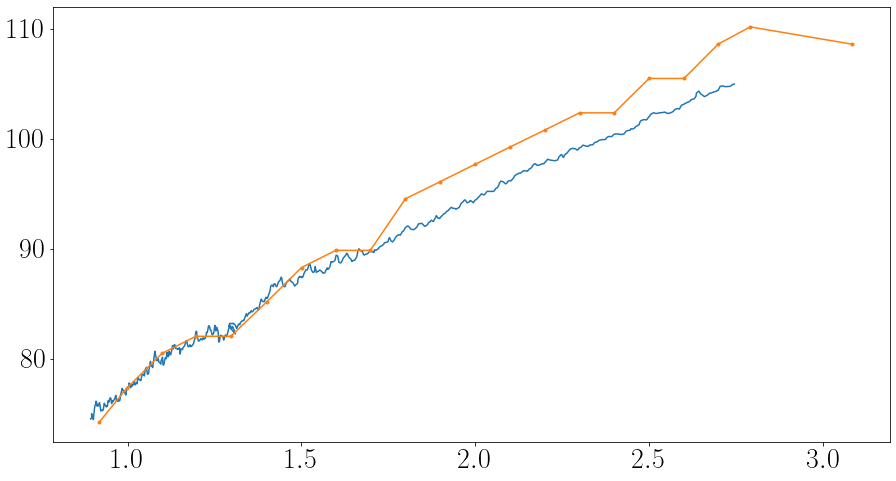

In [29]:
fig, ax = plt.subplots()
ax.plot(-round_df['N:IWCMI_recalibrated_to_IWCMI_absolute'] ,
        0.5*1000*(round_df['ex_um']+round_df['ey_um']))
ax.plot(et_df['I (mA)'], 1000*et_df['e'], '.-')

In [30]:
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
lt_df = pd.read_csv(shift.get_results_dir().fi("life_time_flat_03_16_2020.csv"),
            index_col=0)
lt_df['N'] = i_to_photoel*lt_df['I (mA)']

In [31]:
ap_df = shift.get_Aperture_X_df()
idx_ac = 778
a_ac_cm = 0.38
beta_ac_cm = lattice_df.loc[idx_ac, 'Beta_cm_X']
dispersion_ac_cm = lattice_df.loc[idx_ac, 'Dispersion_cm_X']
ex_ac_um = 1e4*a_ac_cm**2/beta_ac_cm
ex_ac_um

22.08329470231749

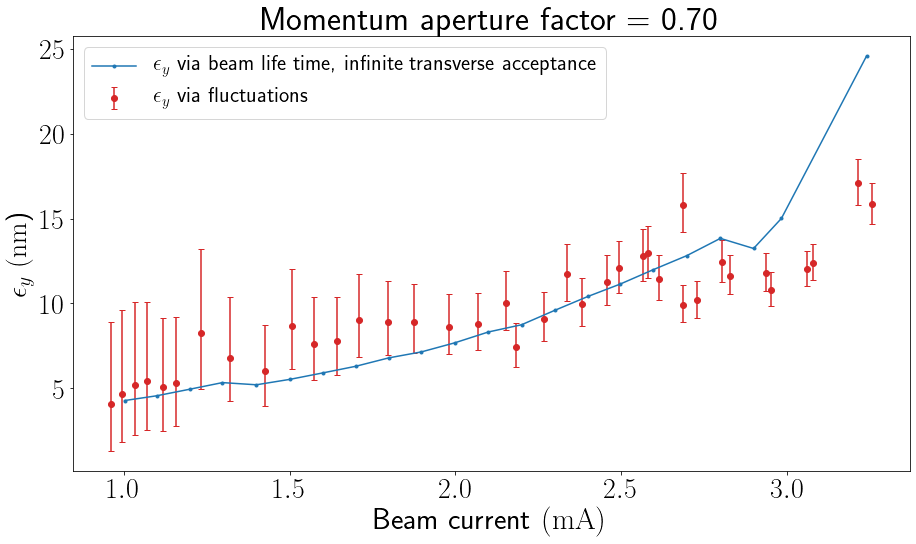

In [32]:
aperture_factor=0.7
def get_ey_from_lifetime_func(
    momentum_aperture,
    fixed_emittance,
    variable_aperture):
    def get_ey_from_lifetime(row):
        Ibeam = row['I (mA)']
        lt = row['Beam life time (Sec)']
        avN = row['N']
        V0 = Vrf_f_func(avN)
        sp = dpp_func(avN)
        ex = ex_f_func(avN)
        sz = sz_f_func(avN)
        lamTska = get_LamTska(lattice_df, V0, sp, ex, sz, Ibeam,
          aperture_factor=momentum_aperture,
          use_transverse_acceptance_octupole=False,
          use_constant_transverse_acceptance=False,
          constant_acceptance_cm=1.0,
          use_transverse_acceptance_by_emittance=fixed_emittance,
          emittance_acceptance_um=ex_ac_um,
          use_variable_aperture_df=variable_aperture,
          variable_aperture_df=ap_df
         )
        return 1e3*(lt*lamTska)**2
    return get_ey_from_lifetime
lt_df['ey_rec_no_transv_acc'] = lt_df.apply(get_ey_from_lifetime_func(
    aperture_factor, False, False), axis=1)
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=\
       r'\usepackage{siunitx}'
      +r'\newcommand{\e}{\epsilon}')
plt.rcParams.update({'figure.figsize':(15,8),
                     'font.size': 28,
                     'legend.fontsize':22,
                     'errorbar.capsize':3})
fs = 28
color='tab:red'
fig, ax = plt.subplots()
yerr = 1e3*np.array([meas_FLAT['ey_error_bottom'],meas_FLAT['ey_error_top']])
ax.errorbar(meas_FLAT['N']/i_to_photoel, 1e3*meas_FLAT['ey_rec'],
             marker='o', linestyle='None',
             color=color, yerr=yerr, label=r'$\e_y$ via fluctuations')
ax.plot(lt_df['I (mA)'], lt_df['ey_rec_no_transv_acc'], '.-',
        label=r"$\e_y$ via beam life time, infinite transverse acceptance")
ax.set_ylabel(r"$\e_y$ $(\SI{}{nm}$)", fontsize=fs)
ax.set_xlabel(r"Beam current $(\SI{}{mA})$")
ax.legend()
plt.title(f"Momentum aperture factor = {aperture_factor:.2f}")
plt.show()

In [33]:
lt_df.to_csv(shift.get_results_dir().fi("life_time_flat_03_16_2020.csv"))

# Flat beam ND filters extract ey from lifetime

In [43]:
from fur.jsonstorage import JsonStorage
sh10 = path_assistant.PathAssistant('shift_03_10_2020')
js10 = JsonStorage(sh10.get_results_dir().fi('jsonstorage_03_10_2020.json'))

In [48]:
lt = js10.get("Lifetime")
sz_ND = js10.get("sz_cm")
ex_ND = js10.get("ex")
dpp_ND = js10.get("dpp")
IbeamND = js10.get("Ibeam")
VND = js10.get("V0")
lamTska = get_LamTska(lattice_df, VND, dpp_ND, ex_ND, sz_ND, IbeamND,
  aperture_factor=aperture_factor,
 )
ey_lt_ND = 1e3*(lt*lamTska)**2
ey_lt_ND

9.600951054942275

In [49]:
js10.save("ey_lifetime_rec", ey_lt_ND)

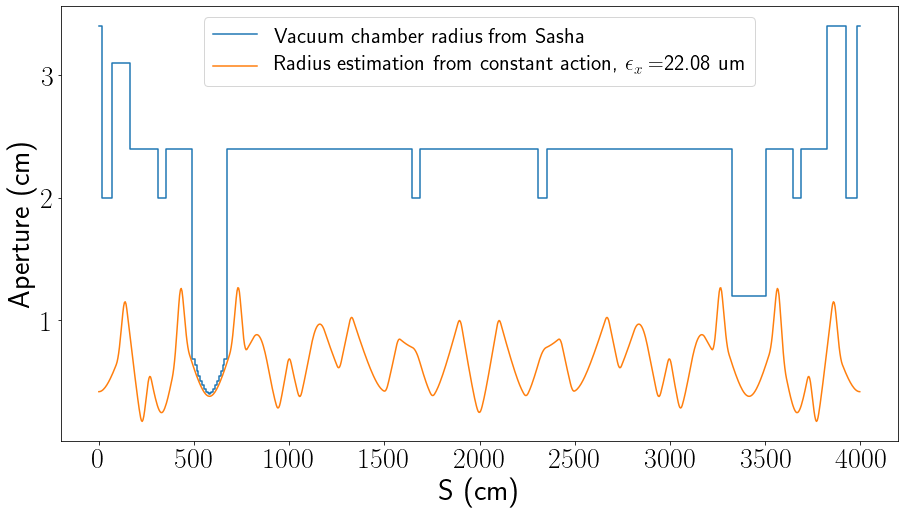

In [34]:

ldf = lattice_df
ap_vs_S = (1e-4*lattice.get_sigma_um(ldf['Beta_cm_X'],   
                ex_ac_um, ldf['Dispersion_cm_X'], 0))
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=\
       r'\usepackage{siunitx}'
      +r'\newcommand{\e}{\epsilon}')
plt.rcParams.update({'figure.figsize':(15,8),
                     'font.size': 28,
                     'legend.fontsize':22,
                     'errorbar.capsize':3})
fig, ax = plt.subplots()
ax.plot(ap_df['S_cm'], ap_df['Aperture_cm_X'],
        label='Vacuum chamber radius from Sasha')
ax.plot(ldf['S_cm'], ap_vs_S, label='Radius estimation from constant action, '
       r"$\e_x = $"+f"{ex_ac_um:.2f} um")
ax.set_ylabel("Aperture (cm)")
ax.set_xlabel("S (cm)")
ax.legend()
plt.show()

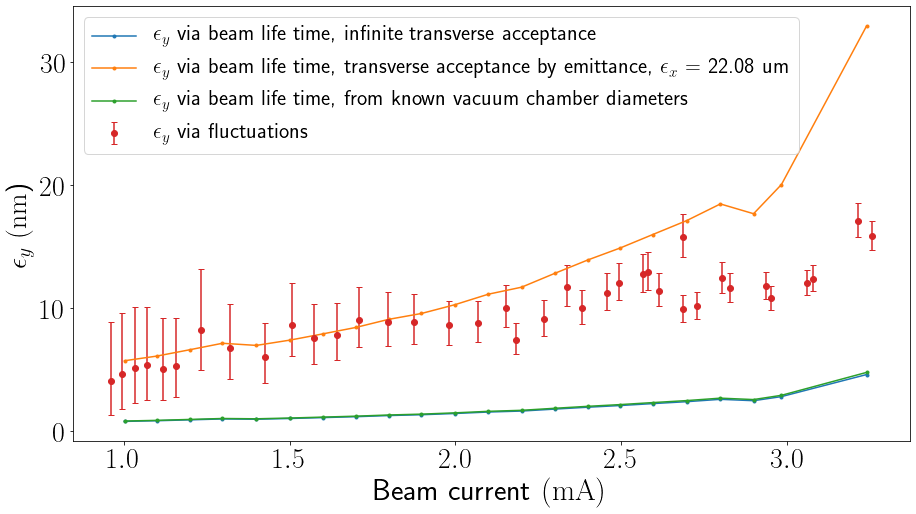

In [35]:

lt_df['N'] = i_to_photoel*lt_df['I (mA)']

def get_ey_from_lifetime_func(
    momentum_aperture,
    fixed_emittance,
    variable_aperture):
    def get_ey_from_lifetime(row):
        Ibeam = row['I (mA)']
        lt = row['Beam life time (Sec)']
        avN = row['N']
        V0 = Vrf_f_func(avN)
        sp = dpp_func(avN)
        ex = ex_f_func(avN)
        sz = sz_f_func(avN)
        lamTska = get_LamTska(lattice_df, V0, sp, ex, sz, Ibeam,
          aperture_factor=momentum_aperture,
          use_transverse_acceptance_octupole=False,
          use_constant_transverse_acceptance=False,
          constant_acceptance_cm=1.0,
          use_transverse_acceptance_by_emittance=fixed_emittance,
          emittance_acceptance_um=ex_ac_um,
          use_variable_aperture_df=variable_aperture,
          variable_aperture_df=ap_df
         )
        return 1e3*(lt*lamTska)**2
    return get_ey_from_lifetime
lt_df['ey_rec_no_transv_acc'] = lt_df.apply(get_ey_from_lifetime_func(
    1.0, False, False), axis=1)
lt_df['ey_rec_transv_acc_by_ex'] = lt_df.apply(get_ey_from_lifetime_func(
    1.0, True, False), axis=1)
lt_df['ey_rec_variable_acc_df'] = lt_df.apply(get_ey_from_lifetime_func(
    1.0, False, True), axis=1)
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=\
       r'\usepackage{siunitx}'
      +r'\newcommand{\e}{\epsilon}')
plt.rcParams.update({'figure.figsize':(15,8),
                     'font.size': 28,
                     'legend.fontsize':22,
                     'errorbar.capsize':3})
fs = 28
color='tab:red'
fig, ax = plt.subplots()
yerr = 1e3*np.array([meas_FLAT['ey_error_bottom'],meas_FLAT['ey_error_top']])
ax.errorbar(meas_FLAT['N']/i_to_photoel, 1e3*meas_FLAT['ey_rec'],
             marker='o', linestyle='None',
             color=color, yerr=yerr, label=r'$\e_y$ via fluctuations')
ax.plot(lt_df['I (mA)'], lt_df['ey_rec_no_transv_acc'], '.-',
        label=r"$\e_y$ via beam life time, infinite transverse acceptance")
ax.plot(lt_df['I (mA)'], lt_df['ey_rec_transv_acc_by_ex'], '.-',
        label=r"$\e_y$ via beam life time, transverse acceptance by emittance"
       r", $\e_x$ = "+f"{ex_ac_um:.2f} um")
ax.plot(lt_df['I (mA)'], lt_df['ey_rec_variable_acc_df'], '.-',
        label=r"$\e_y$ via beam life time, from known vacuum chamber diameters")
ax.set_ylabel(r"$\e_y$ $(\SI{}{nm}$)", fontsize=fs)
ax.set_xlabel(r"Beam current $(\SI{}{mA})$")
ax.legend()
# plt.title(f"Momentum acceptance multiplier = {ap:.2f}")
plt.show()